### ДЗ 6. Урок 6. Градиентный бустинг (AdaBoost)

### -- Автор: Шенк Евгений Станиславович

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

### Задание 6.1.

1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. 
Сделать выводы о зависимости ошибки от этих параметров.

### Выполнено: ниже выполнено задание с кодом из методички и с кодом из д.з. (переделаным для регрессии)

### Дерево

In [2]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [3]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        prediction = np.mean(self.labels)
        return prediction      

In [4]:
# Расчет качества

def quality(left_labels, right_labels, current_var):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_var - p * np.var(left_labels) - (1 - p) * np.var(right_labels)

In [5]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [6]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    #len_subsample = int(np.sqrt(len_sample))
    len_subsample = int((len_sample))
    subsample = []
    
    random.seed(42)
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [7]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf):
    
    #  обозначим минимальное количество объектов в узле
    # min_leaf = 5
    min_data_len = len(data) * min_leaf / 100

    current_var = np.var(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            #if len(true_data) < min_leaf or len(false_data) < min_leaf:
            if len(true_data) < min_data_len or len(false_data) < min_data_len:
                continue
            
            current_quality = quality(true_labels, false_labels, current_var)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [8]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [9]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [10]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [11]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, min_leaf=1, max_leaves=20, tree_depth=20):

    quality, t, index = find_best_split(data, labels, min_leaf)

    #  1. Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    #  2. прекращаем рекурсию, когда достигнута максимальная глубина дерева
    #  3. прекращаем рекурсию, когда достигнуто максимальное количество листьев 
    #  (количество листьев считаем по кол-ву Нодов + 1)    
    if quality == 0 or tree_depth == 0 or max_leaves <= 1:
        max_leaves += 1
        return Leaf(data, labels), max_leaves

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    max_leaves -= 2
    
    # Рекурсивно строим два поддерева
    true_branch, max_leaves = build_tree(true_data, true_labels, min_leaf, max_leaves, tree_depth = tree_depth - 1)
    false_branch, max_leaves = build_tree(false_data, false_labels, min_leaf, max_leaves, tree_depth = tree_depth - 1)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch), max_leaves

## Градиентный бустинг

### Был добавлен вариант расчетов с помощью кода без SciPy

In [12]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [13]:
def bias(y, z):
    return (y - z)

In [14]:
def gb_predict(X, trees_list, coef_list, eta, method='scipy'):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    if method == 'scipy':
        return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])
    else:
        return np.array([sum([eta* coef * classify_object(x, alg) for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [15]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, method='scipy'):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        if method == 'scipy':
            tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            if method == 'scipy':
                tree.fit(X_train, y_train)
            else:
                tree = build_tree(X_train, y_train, tree_depth=max_depth)[0]
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta, method)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta, method)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta, method)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            if method == 'scipy':
                tree.fit(X_train, bias(y_train, target))
            else:
                tree = build_tree(X_train, bias(y_train, target), tree_depth=max_depth)[0]
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta, method)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta, method)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [16]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
from sklearn import model_selection
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=2177)

In [17]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, method='scipy'):
    train_prediction = gb_predict(X_train, trees, coefs, eta, method)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta, method)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [18]:
# Грфик зависимости MSE от количества деревьев (итераций)
def get_error_plot_n_trees(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [19]:
# Грфик зависимости MSE от максимальной глубины дерева
def get_error_plot_max_depth(max_depth, train_err, test_err):
    plt.xlabel('Max_depth')
    plt.ylabel('MSE')
    plt.xlim(1, max_depth)
    plt.plot(list(range(1, max_depth)), train_err, label='train error')
    plt.plot(list(range(1, max_depth)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

### Вариант с кодом из занятия (с SciPy)

In [20]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 6

# Шаг
eta = 1

# С использованием SciPy или без него
method='scipy'

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, method)

In [21]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, method='scipy')

Ошибка алгоритма из 10 деревьев глубиной 6     с шагом 1 на тренировочной выборке: 42.048713863290345
Ошибка алгоритма из 10 деревьев глубиной 6     с шагом 1 на тестовой выборке: 6061.456758081945


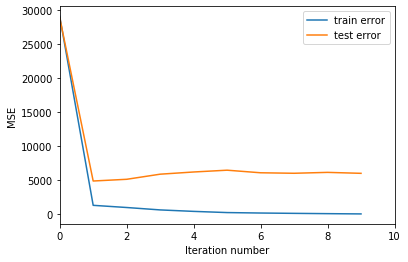

In [22]:
get_error_plot_n_trees(n_trees, train_errors, test_errors)

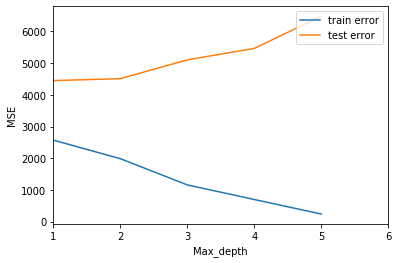

In [23]:
train_err = []
test_err = []
index = n_trees-1

for depth in range(1, max_depth):
    trees, train_errors, test_errors = gb_fit(n_trees, depth, X_train, X_test, y_train, y_test, coefs, eta, method)
    train_err.append(train_errors[index])
    test_err.append(test_errors[index])
    
get_error_plot_max_depth(max_depth, train_err, test_err)

### Вариант с кодом без SciPy

In [24]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 6

# Шаг
eta = 1

# С использованием SciPy или без него
method='not_scipy'

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, method)

In [25]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta, method='not_scipy')

Ошибка алгоритма из 10 деревьев глубиной 6     с шагом 1 на тренировочной выборке: 305.00485567830236
Ошибка алгоритма из 10 деревьев глубиной 6     с шагом 1 на тестовой выборке: 6647.015298220546


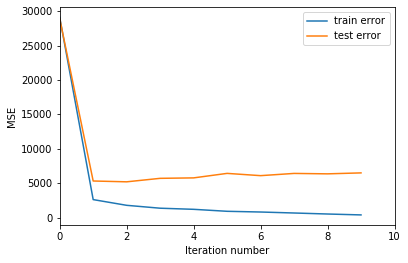

In [26]:
get_error_plot_n_trees(n_trees, train_errors, test_errors)

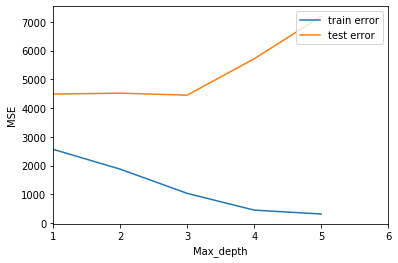

In [27]:
train_err = []
test_err = []
index = n_trees-1

for depth in range(1, max_depth):
    trees, train_errors, test_errors = gb_fit(n_trees, depth, X_train, X_test, y_train, y_test, coefs, eta, method)
    train_err.append(train_errors[index])
    test_err.append(test_errors[index])
    
get_error_plot_max_depth(max_depth, train_err, test_err)

### Задание 6.2.

2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. 
    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

In [28]:
# Грфик зависимости MSE от количества деревьев (итераций) и типа градиентного бустинга
def get_error_plot_sgb(n_trees, test_err, test_err_sgb):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), test_err, label='test error (normal)')
    plt.plot(list(range(n_trees)), test_err_sgb, label='test error (SGB)')
    plt.legend(loc='upper right')
    plt.show()

In [29]:
def get_sample(X_train, y_train, part=0.5):
    indexes = random.sample(range(len(X_train)), int(len(X_train) * part))
    return X_train[indexes], y_train[indexes]

In [30]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, part=0.5, method='scipy'):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        
        X_train_partial, y_train_partial = get_sample(X_train, y_train, part)
        
        if method == 'scipy':
            tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            if method == 'scipy':
                tree.fit(X_train_partial, y_train_partial)
            else:
                tree = build_tree(X_train_partial, y_train_partial, tree_depth=max_depth)[0]
            
            train_errors.append(mean_squared_error(y_train_partial, gb_predict(X_train_partial, trees, coefs, eta, method)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta, method)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_partial, trees, coefs, eta, method)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            if method == 'scipy':
                tree.fit(X_train_partial, bias(y_train_partial, target))
            else:
                tree = build_tree(X_train_partial, bias(y_train_partial, target), tree_depth=max_depth)[0]
            
            train_errors.append(mean_squared_error(y_train_partial, gb_predict(X_train_partial, trees, coefs, eta, method)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta, method)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [31]:
# Число деревьев в ансамбле
n_trees = 12

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.5

# Размер выборки для стохастического градиентного бустинга
part = 0.5

# С использованием SciPy или без него
method='scipy'

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, method)
sgb_trees, sgb_train_errors, sgb_test_errors = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, part, method)

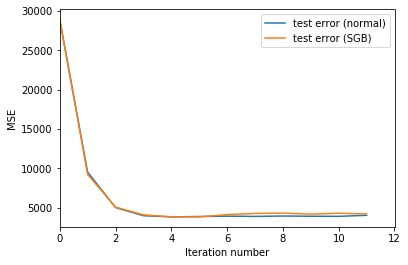

In [32]:
get_error_plot_sgb(n_trees, test_errors, sgb_test_errors)

### Выводы: Ошибка получилась такой же, или чуть выше